In [1]:
# Run R kernel first then switch to Python kernel

In [2]:
setwd("/Users/bekterra/Desktop/Hackatons/Flight Delay/flightsDB")
library(data.table)
# merging datasets into one dataframe
MergedFlights.df <-
  do.call(rbind,
          lapply(list.files(path = "/Users/bekterra/Desktop/Hackatons/Flight Delay/flightsDB/"), read.csv))

summary(MergedFlights.df)

      YEAR          MONTH         DAY_OF_MONTH    DAY_OF_WEEK   
 Min.   :2015   Min.   : 1.000   Min.   : 1.00   Min.   :1.000  
 1st Qu.:2016   1st Qu.: 4.000   1st Qu.: 8.00   1st Qu.:2.000  
 Median :2016   Median : 7.000   Median :16.00   Median :4.000  
 Mean   :2016   Mean   : 6.554   Mean   :15.77   Mean   :3.921  
 3rd Qu.:2016   3rd Qu.: 9.000   3rd Qu.:23.00   3rd Qu.:6.000  
 Max.   :2016   Max.   :12.000   Max.   :31.00   Max.   :7.000  
                                                                
 UNIQUE_CARRIER    ORIGIN_AIRPORT_ID DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID
 WN     :1296114   Min.   :10135     Min.   :10135   Min.   :1013503    
 DL     : 921773   1st Qu.:11292     1st Qu.:11292   1st Qu.:1129202    
 AA     : 917255   Median :12889     Median :12889   Median :1288903    
 OO     : 603895   Mean   :12679     Mean   :12679   Mean   :1267923    
 UA     : 542792   3rd Qu.:14027     3rd Qu.:14027   3rd Qu.:1402702    
 EV     : 497617   Max.   :16218     Max. 

In [3]:
#Saving combined dataframe 
output.filename <- "CombinedFlights.csv"
write.csv(MergedFlights.df, output.filename)

In [4]:
# loading datasets
library(data.table)
airportsDB <- read.csv('/Users/bekterra/Desktop/Hackatons/Flight Delay/Airport_Lookup.csv',
                       header = TRUE, stringsAsFactors = FALSE)
carriersDB <- read.csv('/Users/bekterra/Desktop/Hackatons/Flight Delay/Carrier_Lookup.csv',
                       header = TRUE, stringsAsFactors = FALSE)
flightsDB <- fread("/Users/bekterra/Desktop/Hackatons/Flight Delay/flightsDB/CombinedFlights.csv",
                      header = TRUE, stringsAsFactors = FALSE)

head(flightsDB)

Read 5635939 rows and 15 (of 15) columns from 0.370 GB file in 00:00:09


V1,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,X
1,2016,4,11,1,F9,11292,13930,1393004,700,1042,-10,162,888,NA
2,2016,4,11,1,F9,13930,12889,1288903,1135,1340,-46,245,1514,NA
3,2016,4,11,1,F9,12889,12266,1226603,1425,1930,14,185,1222,NA
4,2016,4,11,1,F9,12266,12889,1288903,2015,2150,-1,215,1222,NA
5,2016,4,11,1,F9,12889,13303,1330303,2320,710,-38,290,2174,NA
6,2016,4,11,1,F9,13303,11292,1129202,705,935,-5,270,1709,NA


In [5]:
# Rid off unneccessary variables
flightsDB <- subset(flightsDB, select = -c(X, YEAR,V1,DEST_AIRPORT_SEQ_ID))

In [6]:
# Missing values
summary(flightsDB$ARR_DELAY)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-152.00  -14.00   -6.00    3.32    6.00 2142.00   80306 

In [7]:
# flights
dim(flightsDB)

[1] 5635939      11

In [8]:
# dropping missing values
flightsDB <- na.omit(flightsDB)
summary(flightsDB)

     MONTH         DAY_OF_MONTH    DAY_OF_WEEK    UNIQUE_CARRIER    
 Min.   : 1.000   Min.   : 1.00   Min.   :1.000   Length:5555633    
 1st Qu.: 4.000   1st Qu.: 8.00   1st Qu.:2.000   Class :character  
 Median : 7.000   Median :16.00   Median :4.000   Mode  :character  
 Mean   : 6.562   Mean   :15.75   Mean   :3.922                     
 3rd Qu.: 9.000   3rd Qu.:23.00   3rd Qu.:6.000                     
 Max.   :12.000   Max.   :31.00   Max.   :7.000                     
 ORIGIN_AIRPORT_ID DEST_AIRPORT_ID  CRS_DEP_TIME   CRS_ARR_TIME 
 Min.   :10135     Min.   :10135   Min.   :   1   Min.   :   1  
 1st Qu.:11292     1st Qu.:11292   1st Qu.: 915   1st Qu.:1105  
 Median :12889     Median :12889   Median :1325   Median :1519  
 Mean   :12680     Mean   :12681   Mean   :1330   Mean   :1490  
 3rd Qu.:14057     3rd Qu.:14057   3rd Qu.:1735   3rd Qu.:1919  
 Max.   :16218     Max.   :16218   Max.   :2359   Max.   :2400  
   ARR_DELAY        CRS_ELAPSED_TIME    DISTANCE     
 Min.   

In [9]:
# Creating a New Feature: Number of Days to Holiday
holidays <- c('2016-01-01', '2016-01-20', '2016-02-17', '2016-05-26',
              '2016-07-04', '2016-09-01', '2016-10-13', '2016-11-11',
              '2016-11-28', '2015-12-25') # Ten major holidays, including Memorial Day, Columbus Day, Labor Day, MLK Day
# Veteran's Day, New Year's, President's Day, Independence Day, Thanksgiving, 
# and Christmas Day.
holidayDates <- as.Date(holidays)

DaysToHoliday <- function(month, day)
{ # Input a month and day from the flightsDB
  
# Get our year.
year <- 2016
  if (month > 11)
  {
    year <- 2015
  }
  # Paste on a 2013 for November and December dates.
  
  currDate <- as.Date(paste(year,month,day,sep = '-')) # Create a DATE object we can use to calculate the time difference
  
  
  numDays <- as.numeric(min(abs(currDate-holidayDates))) # Now find the minimum difference between the date and our holidays
  return(numDays)                                        # We can vectorize this to automatically find the minimum closest
  # holiday by subtracting all holidays at once
  
}

datesOfYear <- unique(flightsDB[,1:2]) # Get all of the dates through unique Month/Day combinations
datesOfYear$HDAYS <- mapply(DaysToHoliday, datesOfYear$MONTH, datesOfYear$DAY_OF_MONTH) 

# Apply our function in a vectorized manner via one of R's many "apply" functions (in this case mapply)
# to each unique date and save
head(datesOfYear)

MONTH,DAY_OF_MONTH,HDAYS
4,11,45
4,12,44
4,13,43
4,21,35
4,22,34
4,23,33


In [10]:
InputDays <- function(month,day){
  finalDays <- datesOfYear$HDAYS[datesOfYear$MONTH == month & datesOfYear$DAY_OF_MONTH == day] # Find which row to get
  return(finalDays)
}

flightsDB$HDAYS <- mapply(InputDays, flightsDB$MONTH, flightsDB$DAY_OF_MONTH)
head(flightsDB)

MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,HDAYS
4,11,1,F9,11292,13930,700,1042,-10,162,888,45
4,11,1,F9,13930,12889,1135,1340,-46,245,1514,45
4,11,1,F9,12889,12266,1425,1930,14,185,1222,45
4,11,1,F9,12266,12889,2015,2150,-1,215,1222,45
4,11,1,F9,12889,13303,2320,710,-38,290,2174,45
4,11,1,F9,13303,11292,705,935,-5,270,1709,45


In [11]:
flightsDB$ARR_HOUR <- trunc(flightsDB$CRS_ARR_TIME/100) # Cuts off the minutes, essentially.
flightsDB$DEP_HOUR <- trunc(flightsDB$CRS_DEP_TIME/100)

In [12]:
library(dtplyr)
head(airportsDB)

Code,Description
10001,"Afognak Lake, AK: Afognak Lake Airport"
10003,"Granite Mountain, AK: Bear Creek Mining Strip"
10004,"Lik, AK: Lik Mining Camp"
10005,"Little Squaw, AK: Little Squaw Airport"
10006,"Kizhuyak, AK: Kizhuyak Bay"
10007,"Klawock, AK: Klawock Seaplane Base"


In [13]:
subset(airportsDB, grepl('New York', Description))

,Code,Description
1637,11703,"New York, NY: Flushing"
2382,12478,"New York, NY: John F. Kennedy International"
2440,12541,"New York, NY: Pan Am Building Heliport"
2444,12545,"New York, NY: West 30th Street Heliport"
2445,12546,"New York, NY: Downtown Manhattan/Wall Street Heliport"
2447,12548,"New York, NY: East 60th Street Heliport"
2825,12953,"New York, NY: LaGuardia"
3633,13784,"New York, NY: New York City Metropolitan Area"
5110,15346,"New York, NY: East 34th Street Heliport"
5582,15859,"New York, NY: World Trade Center Heliport"


In [14]:
MaxFlightsCode <- function(code){
  # Calculates the most likely flights based on flight frequency.
  codeFrame <- subset(flightsDB, ORIGIN_AIRPORT_ID == code)
  numFlights <- dim(codeFrame)[1]
  # Get the number of rows in this frame
  return(numFlights)
}


AirportCode <- function(city){
  codes <- subset(airportsDB, grepl(city, Description))
  # Find all of the airports matching the city we entered
  codes$NumFlights <- sapply(codes$Code, MaxFlightsCode)
  # Collect how many flights exist in the database starting at this airport
  codes <- subset(codes, NumFlights == max(NumFlights))$Code
  # Return our top airport
  return(codes)
}


AirportCode('New York')

[1] 12478


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



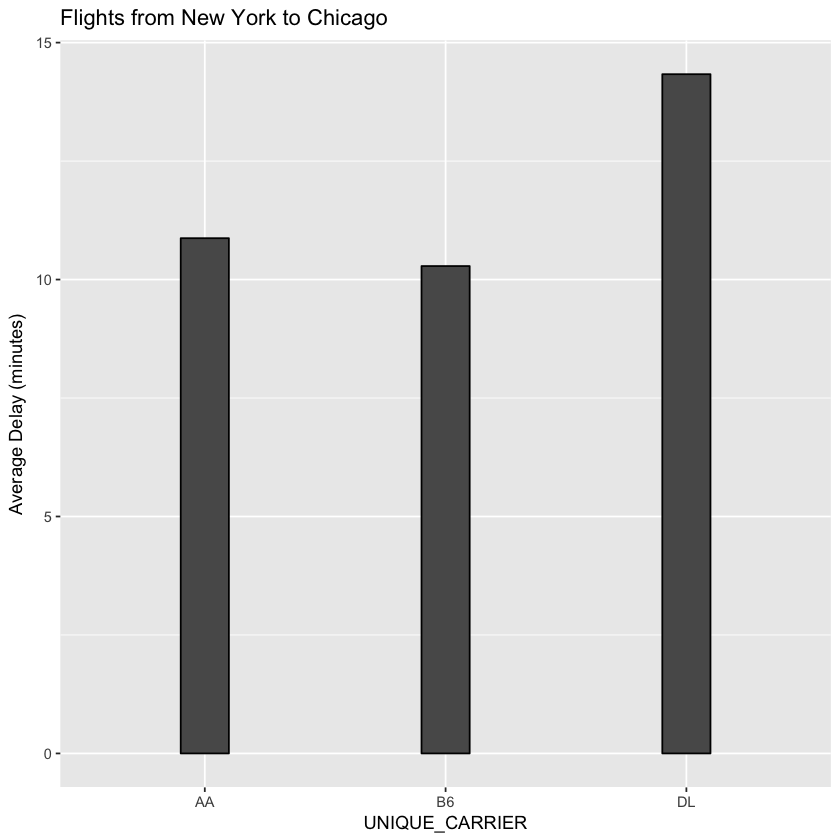

In [15]:
library(dtplyr)
GrouperFunc <- function(df, ...) df %>% group_by_(.dots =...)

library(ggplot2)
AirPlot <- function(departure, arrival, groupon){
  # Departure and arrival can be cities that are being entered.
  departCode <- AirportCode(departure)
  arriveCode <- AirportCode(arrival) # Call our earlier AirportCode function to get the airport ID 
  
  tempDB <- subset(flightsDB, ORIGIN_AIRPORT_ID == departCode & DEST_AIRPORT_ID == arriveCode) # Only get flights for our 
  grouped <- GrouperFunc(tempDB, groupon)                                                       # flight path
  # Use our GrouperFunc to have dplyr group our data into categories   
  summaryDF <- summarize(grouped, mean = mean(ARR_DELAY)) # Call summarize from our grouped data frame
  
  # Now that the data is in a good format, create the ggplot bar chart
  
  finalBarPlot <- ggplot(summaryDF, aes_string(x=groupon, y='mean')) +
    geom_bar(color="black", width = 0.2, stat = 'identity') +
    guides(fill=FALSE)+
    xlab(groupon) + 
    ylab('Average Delay (minutes)')+
    ggtitle((paste('Flights from', departure, 'to', arrival)))
  
  return(finalBarPlot)
}

AirPlot('New York', 'Chicago', 'UNIQUE_CARRIER')

In [16]:
subset(carriersDB, grepl('^AA$|^B6$|^DL$', Code))

,Code,Description
149,AA,American Airlines Inc.
314,B6,JetBlue Airways
494,DL,Delta Air Lines Inc.


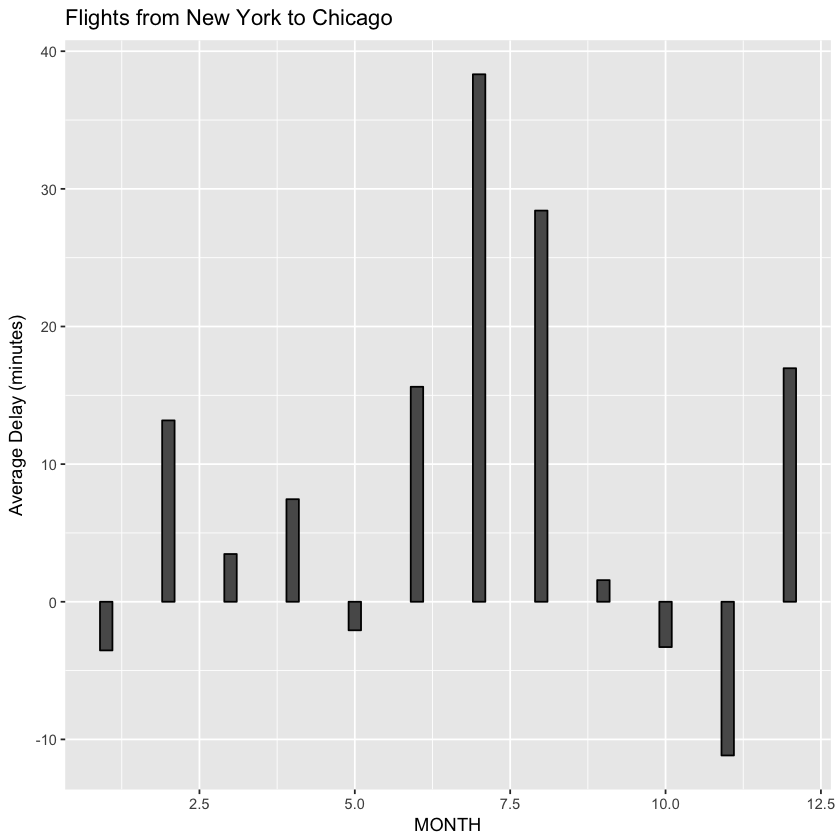

In [17]:
AirPlot('New York', 'Chicago', 'MONTH')

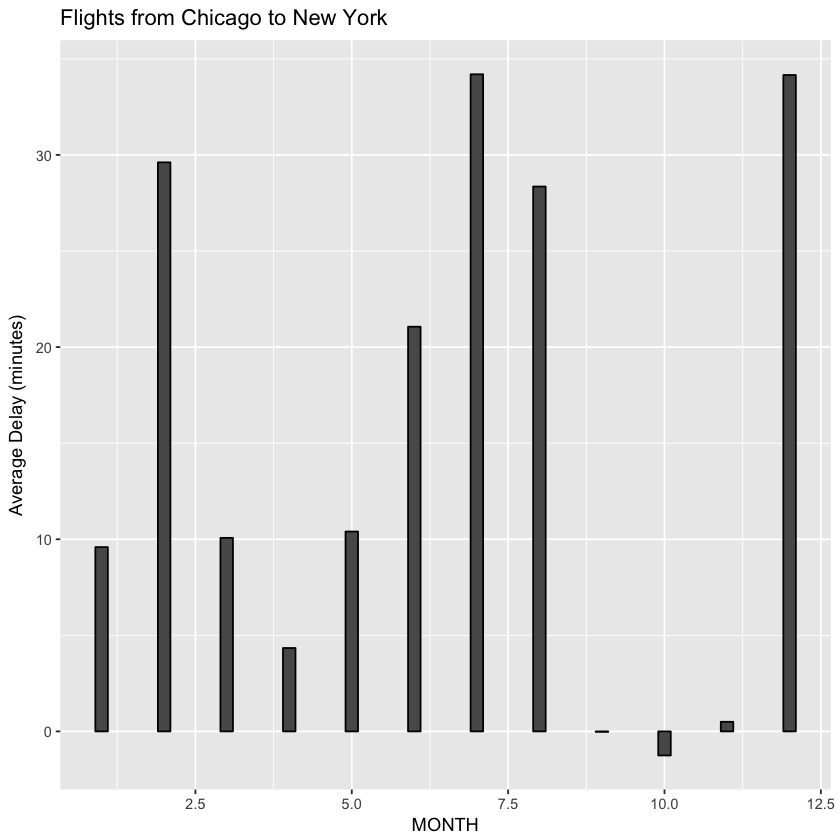

In [18]:
AirPlot('Chicago', 'New York', 'MONTH')

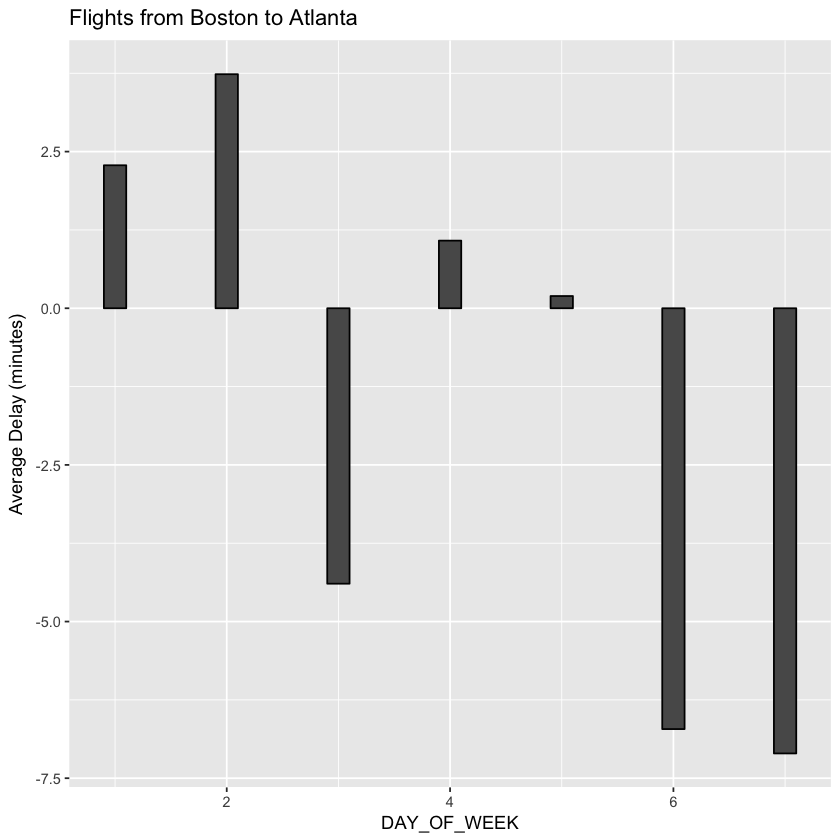

In [19]:
AirPlot('Boston', 'Atlanta', 'DAY_OF_WEEK')

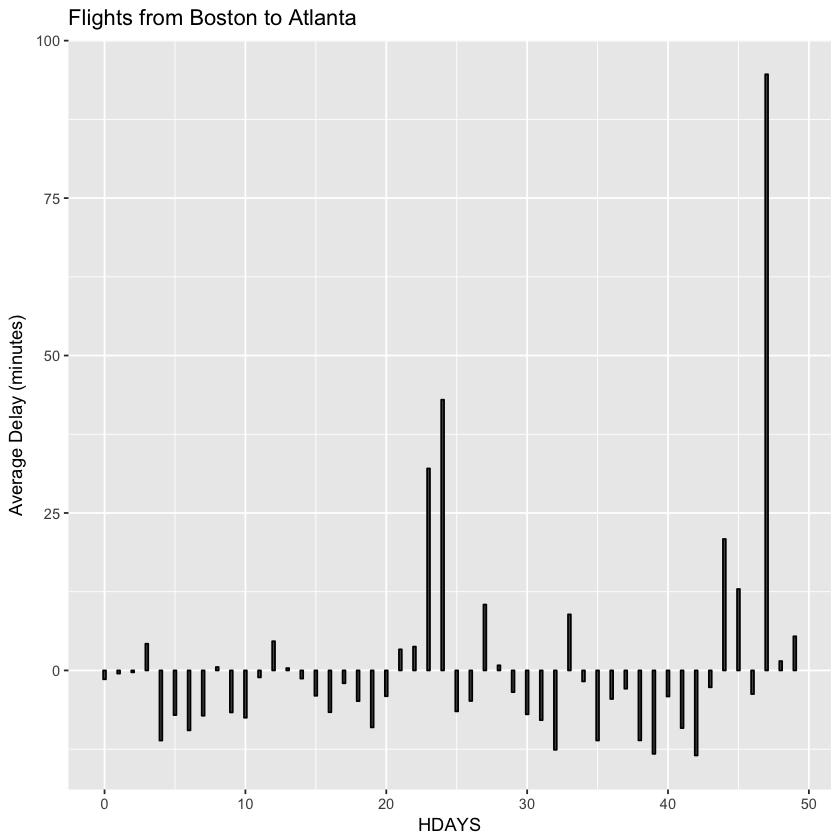

In [20]:
AirPlot('Boston', 'Atlanta', 'HDAYS')

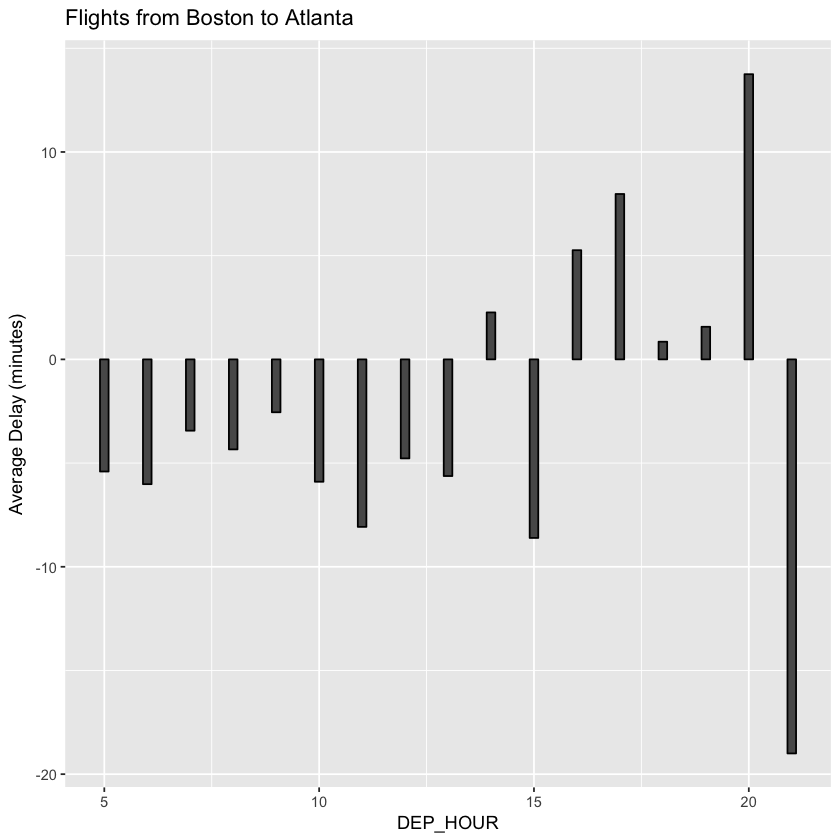

In [21]:
AirPlot('Boston', 'Atlanta', 'DEP_HOUR')

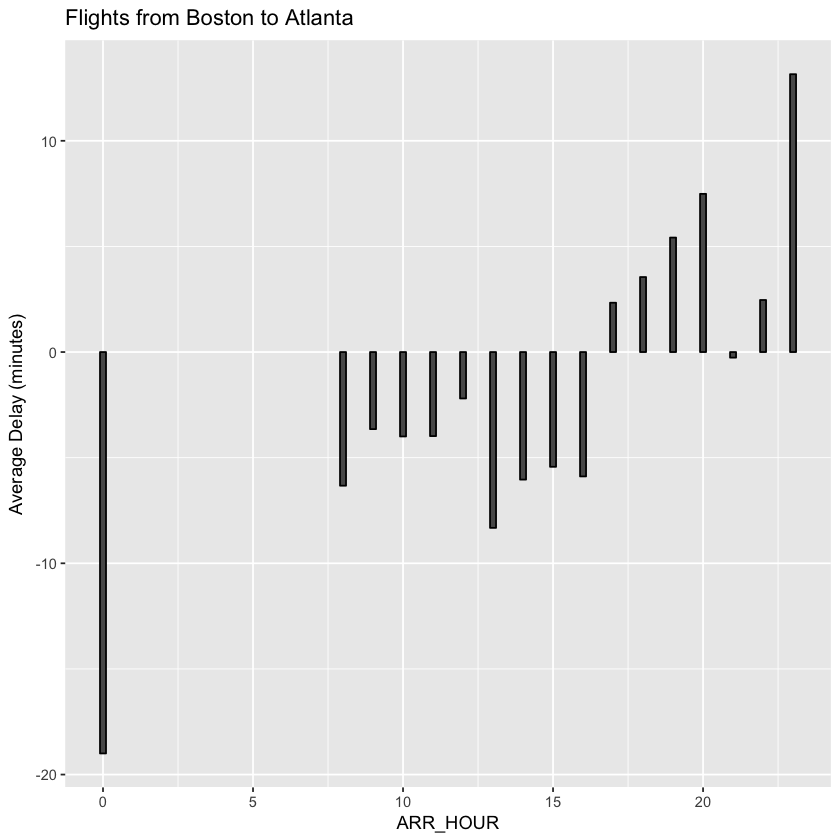

In [22]:
AirPlot('Boston', 'Atlanta', 'ARR_HOUR')

In [5]:
flightsDB$CARRIER_CODE <- as.numeric(as.factor(flightsDB$UNIQUE_CARRIER))
head(flightsDB)

V1,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,X,CARRIER_CODE
1,2016,4,11,1,F9,11292,13930,1393004,700,1042,-10,162,888,NA,6
2,2016,4,11,1,F9,13930,12889,1288903,1135,1340,-46,245,1514,NA,6
3,2016,4,11,1,F9,12889,12266,1226603,1425,1930,14,185,1222,NA,6
4,2016,4,11,1,F9,12266,12889,1288903,2015,2150,-1,215,1222,NA,6
5,2016,4,11,1,F9,12889,13303,1330303,2320,710,-38,290,2174,NA,6
6,2016,4,11,1,F9,13303,11292,1129202,705,935,-5,270,1709,NA,6


In [ ]:
numericDB <- select(flightsDB, -c(CRS_DEP_TIME, CRS_ARR_TIME))
write.csv(numericDB, 'FinalFlightsNumeric.csv')

In [2]:
#Regression Model to Predict Flight Delays (Python)
import pandas as pd
import io
import time

 
#airport_lookupDF = pd.read_csv(os.path.join("/Users/bekterra/Desktop/Hackatons/Flight Delay/Airport_Lookup.csv"),header = 0)

airport_lookupDF = pd.read_csv(r'/Users/bekterra/Desktop/Hackatons/Flight Delay/Airport_Lookup.csv',header = 0) # Airport codes

trainDF = pd.read_csv('/Users/bekterra/Desktop/Hackatons/Flight Delay/flightsDB/FinalFlightsNumeric.csv', header = 0) # Data from R

trainDF.head()

,Unnamed: 0,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,HDAYS,ARR_HOUR,DEP_HOUR,CARRIER_CODE
0,1,4,11,1,F9,11292,13930,-10,162,888,45,10,7,6
1,2,4,11,1,F9,13930,12889,-46,245,1514,45,13,11,6
2,3,4,11,1,F9,12889,12266,14,185,1222,45,19,14,6
3,4,4,11,1,F9,12266,12889,-1,215,1222,45,21,20,6
4,5,4,11,1,F9,12889,13303,-38,290,2174,45,7,23,6


In [3]:
trainDF.drop(trainDF.columns[0], axis = 1, inplace = True)
carrierDF = trainDF[['UNIQUE_CARRIER', 'CARRIER_CODE']].drop_duplicates() # Only get unique examples
carrierDF.head()

,UNIQUE_CARRIER,CARRIER_CODE
0,F9,6
1443,HA,7
7688,NK,9
14580,DL,4
19255,OO,10


In [4]:
trainDF.drop('UNIQUE_CARRIER', axis = 1, inplace = True)
hdaysDF = trainDF[['MONTH', 'DAY_OF_MONTH', 'HDAYS']].drop_duplicates()
scalingDF = trainDF[['DISTANCE', 'HDAYS']].astype('float') # Numerical features
categDF = trainDF[['MONTH', 'DAY_OF_MONTH', 'ORIGIN_AIRPORT_ID', 
                   'DEST_AIRPORT_ID', 'ARR_HOUR', 'DEP_HOUR', 
                   'CARRIER_CODE', 'DAY_OF_WEEK']] # Categorical features

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder() # Create encoder object
categDF_encoded = encoder.fit_transform(categDF) # Can't convert this to dense array: too large!

type(categDF_encoded)

scipy.sparse.csr.csr_matrix

In [6]:
from scipy import sparse # Need this to create a sparse array
scalingDF_sparse = sparse.csr_matrix(scalingDF)

x_final = sparse.hstack((scalingDF_sparse, categDF_encoded))

y_final = trainDF['ARR_DELAY'].values

from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final,y_final,test_size = 0.2,random_state = 0) # Do 80/20 split

x_train_numerical = x_train[:, 0:2].toarray() # We only want the first two features which are the numerical ones.
x_test_numerical = x_test[:, 0:2].toarray()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # create scaler object
scaler.fit(x_train_numerical) # fit with the training data ONLY
x_train_numerical = sparse.csr_matrix(scaler.transform(x_train_numerical)) # Transform the data and convert to sparse
x_test_numerical = sparse.csr_matrix(scaler.transform(x_test_numerical))

x_train[:, 0:2] = x_train_numerical
x_test[:, 0:2] = x_test_numerical

/Users/bekterra/anaconda/lib/python3.5/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [7]:
# Training The Model
from sklearn.linear_model import SGDRegressor
from sklearn.grid_search import GridSearchCV
import numpy as np

SGD_params = {'alpha': 10.0**-np.arange(1,7)} # Suggested range we try
SGD_model = GridSearchCV(SGDRegressor(random_state = 0), SGD_params, scoring = 'mean_absolute_error', cv = 5) # Use 5-fold CV 
SGD_model.fit(x_train, y_train) # Fit the model

from sklearn.metrics import mean_absolute_error

y_true, y_pred = y_test, SGD_model.predict(x_test) # Predict on our test set

print ('Mean absolute error of SGD regression was:')
print(mean_absolute_error(y_true, y_pred))

Mean absolute error of SGD regression was:
20.9266267779


In [8]:
import json
import yaml
import requests

# Function Implementation    
def max_num_flights(codes):
 
    num_store = np.zeros(len(codes)) # Store all possible airport codes
    
    if len(codes) < 1:
        print('Try entering your city/airport again. No matching airports found.') # In case the aiport didn't show up 
        return                                                                     # in the data
    
    for i in range(len(codes)):
        num_flights = trainDF.MONTH[trainDF.ORIGIN_AIRPORT_ID == codes[i]].count() # Count number of rows in data for each
        num_store[i] = num_flights                                                 # airport code
       
    
    # Now find the maximum row
    
    max_ind = int(np.where(num_store == max(num_store))[0])
    # Now we know which code had the most flights. Return it.
    return(codes[max_ind])

In [9]:
def delay_prediction(origin = 'Fort Worth', destination = 'Chicago', carrier = 'American', 
                      dept_time = 17, arr_time = 19, month = 5, day = 15, weekday = 'Wednesday'):
                      
    
    # Create a dict for our Airlines. Based on the carrierDF.
     
    carrier_dict = {'Endeavor':1, 'American':2, 'Alaska':3, 'JetBlue':4, 'Delta':5,
                     'ExpressJet':6, 'Frontier':7, 'AirTran':8, 'Hawaiian':9, 'Envoy':10,
                     'SkyWest':11, 'United':12, 'US Airways':13, 'Virgin':14,
                     'Southwest':15, 'Mesa':16}
                     
    # Another for day of the week
     
    weekday_dict = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4,
                     'Friday':5, 'Saturday':6, 'Sunday':7}
                     
    # Now find the corresponding airport codes for our origin and destination. 
     
    origin_codes = list(airport_lookupDF[airport_lookupDF.Description.str.contains(origin)].Code)
    destination_codes = list(airport_lookupDF[airport_lookupDF.Description.str.contains(destination)].Code)
     
    # From these codes found in the lookup table, see which one had the largest number of flights.
                                                                                                                                                                                                                                                                                                                                     
    origin_code = max_num_flights(origin_codes)
    destination_code = max_num_flights(destination_codes)
     
    # Now that we have these codes, we can look up the other parameters necessary.
     
    # Start with looking up HDAYS.
     
    hdays = np.array(float(hdaysDF[(hdaysDF.MONTH == month) & (hdaysDF.DAY_OF_MONTH == day)].HDAYS))
     
    # Now find the distance between the two airports. Add a try/except to catch any problems.
   
    try:
        distance = np.array(float(trainDF[(trainDF.ORIGIN_AIRPORT_ID == origin_code) & 
                              (trainDF.DEST_AIRPORT_ID == destination_code)].DISTANCE.drop_duplicates()))
    except:
        print ('Route was not found in the data. Please try a different nearby city or a new route.')
        return
     
    carrier_num = carrier_dict[carrier]
    weekday_num = weekday_dict[weekday]
     
    # Now that we have all of our values, we can start combining them together.
     
    # First, create our numeric array of distance and hdays.
     
    numerical_values = np.c_[distance, hdays]
     
    # Scale the features
     
    numerical_values_scaled = scaler.transform(numerical_values)
     
    # Now create our array of categorical values.
     
    categorical_values = np.zeros(8)
    categorical_values[0] = int(month)
    categorical_values[1] = int(day)
    categorical_values[2] = int(origin_code)
    categorical_values[3] = int(destination_code)
    categorical_values[4] = int(arr_time)
    categorical_values[5] = int(dept_time)
    categorical_values[6] = int(carrier_num)
    categorical_values[7] = int(weekday_num)
     
    # Apply the one-hot encoding to these.
     
    categorical_values_encoded = encoder.transform([categorical_values]).toarray()
     
    # Combine these into the final test example that goes into the model
     
    final_test_example = np.c_[numerical_values_scaled, categorical_values_encoded]
     
    # Now predict this with the model 
     
    pred_delay = SGD_model.predict(final_test_example)
    print ('Your predicted delay is', int(pred_delay[0]), 'minutes.')
    return # End of function


In [10]:
delay_prediction(origin = 'Washington, DC', destination = 'Miami, FL', 
                  carrier = 'United', dept_time = 17, arr_time = 21,
                  month = 3, day = 19, weekday = 'Thursday')


Your predicted delay is 12 minutes.


In [11]:
delay_prediction(origin = 'Dallas', destination = 'Chicago', 
                carrier = 'American', dept_time = 17, arr_time = 20,
                month = 1, day = 28, weekday = 'Wednesday')


Your predicted delay is 8 minutes.


In [ ]:
## Deploying model into production
MODEL_ATTRS = [ 'origin' , 'destination' , 'carrier' , 'dept_time' , 'arr_time' ,
                  'month', 'day', 'weekday' ]
                
if request.method == 'POST': # you submitted the form

        attributes = [] # just the values from the form in an array
        for field in MODEL_ATTRS:
            attributes.append(request.form[field])
        result = delay_prediction(attributes)
        result = result.json()
        


API_KEY = 'xxxxxxx'

def delay_prediction(attributes):
    return requests.post(
        "https://trial.dominodatalab.com/v1/bekterra/FlightDelay/endpoint",
        headers = {
            'X-Domino-Api-Key': "xxxxx",
            'Content-type': 'application/json'
        },
        json={ "parameters": attributes }
)
